In [3]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.core.pylabtools import figsize
from sympy import false
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob

from unicodedata import bidirectional

from RNN_HAR_TimeSereis import x_batch


In [4]:
class Gate(nn.Module):
    def __init__(self, hidden_size, af):
        super().__init__()
        self.fch = nn.LazyLinear(hidden_size)
        self.fcx = nn.LazyLinear(hidden_size)
        self.af = nn.Sigmoid() if af == 'sigmoid' else nn.Tanh()

    def forward(self, x, h):
        return self.af(self.fcx(x) + self.fch(h))

In [5]:
mygate = Gate(hidden_size=32, af='tanh')
mygate(torch.randn(3, 32), torch.randn(3, 24)).shape

torch.Size([3, 32])

In [17]:
class LSTM_Custom_Model(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.forget_gate = Gate(hidden_size, af='sigmoid')
        self.input_gate = Gate(hidden_size, af='sigmoid')
        self.output_gate = Gate(hidden_size, af='sigmoid')
        self.gate = Gate(hidden_size, af='tanh')

    def forward(self, x):
        ht = torch.zeros(self.hidden_size)
        ct = torch.zeros(self.hidden_size)
        output = []
        #
        for xt in x:
            ft = self.forget_gate(xt, ht)
            ct = ct * ft
            #
            gt = self.gate(xt, ht)
            it = self.input_gate(xt, ht)
            ct = ct + gt * it
            #
            ot = self.output_gate(xt, ht)
            ht = ot * torch.tanh(ct)
            output.append(ht)
        return output, ht, ct


In [18]:
lstm = LSTM_Custom_Model(32)
lstm

LSTM_Custom_Model(
  (forget_gate): Gate(
    (fch): LazyLinear(in_features=0, out_features=32, bias=True)
    (fcx): LazyLinear(in_features=0, out_features=32, bias=True)
    (af): Sigmoid()
  )
  (input_gate): Gate(
    (fch): LazyLinear(in_features=0, out_features=32, bias=True)
    (fcx): LazyLinear(in_features=0, out_features=32, bias=True)
    (af): Sigmoid()
  )
  (output_gate): Gate(
    (fch): LazyLinear(in_features=0, out_features=32, bias=True)
    (fcx): LazyLinear(in_features=0, out_features=32, bias=True)
    (af): Sigmoid()
  )
  (gate): Gate(
    (fch): LazyLinear(in_features=0, out_features=32, bias=True)
    (fcx): LazyLinear(in_features=0, out_features=32, bias=True)
    (af): Tanh()
  )
)

In [23]:
output, ht, ct = lstm(torch.randn(5, 10))

In [24]:
len(output)

5

In [25]:
output[0].shape

torch.Size([32])

In [30]:
#function load dataset
def har_dataset(phase):
    x = []
    data_dir = f'HAR_Dataset/{phase}/Inertial Signals/*'
    for file_dir in glob.glob(data_dir):
        x.append(np.loadtxt(file_dir))
    y = np.loadtxt(f'HAR_Dataset/{phase}/y_{phase}.txt')
    #x,y to Tensor
    x = torch.FloatTensor(x).permute(1, 2, 0)
    y = torch.LongTensor(y) - 1
    return x, y

In [28]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

In [32]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [33]:
x_test.shape, y_test.shape

(torch.Size([2947, 128, 9]), torch.Size([2947]))

In [34]:
y_train

tensor([4, 4, 4,  ..., 1, 1, 1])

In [35]:
#label
torch.unique(y_train)

tensor([0, 1, 2, 3, 4, 5])

In [36]:
# Tensor Dataset
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

In [38]:
#dataloader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

In [52]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([256, 128, 9]) torch.Size([256])


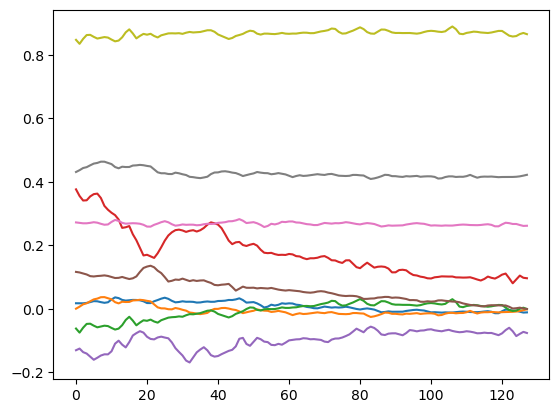

In [53]:
#plot one sample
plt.plot(x[0])
# plt.show()

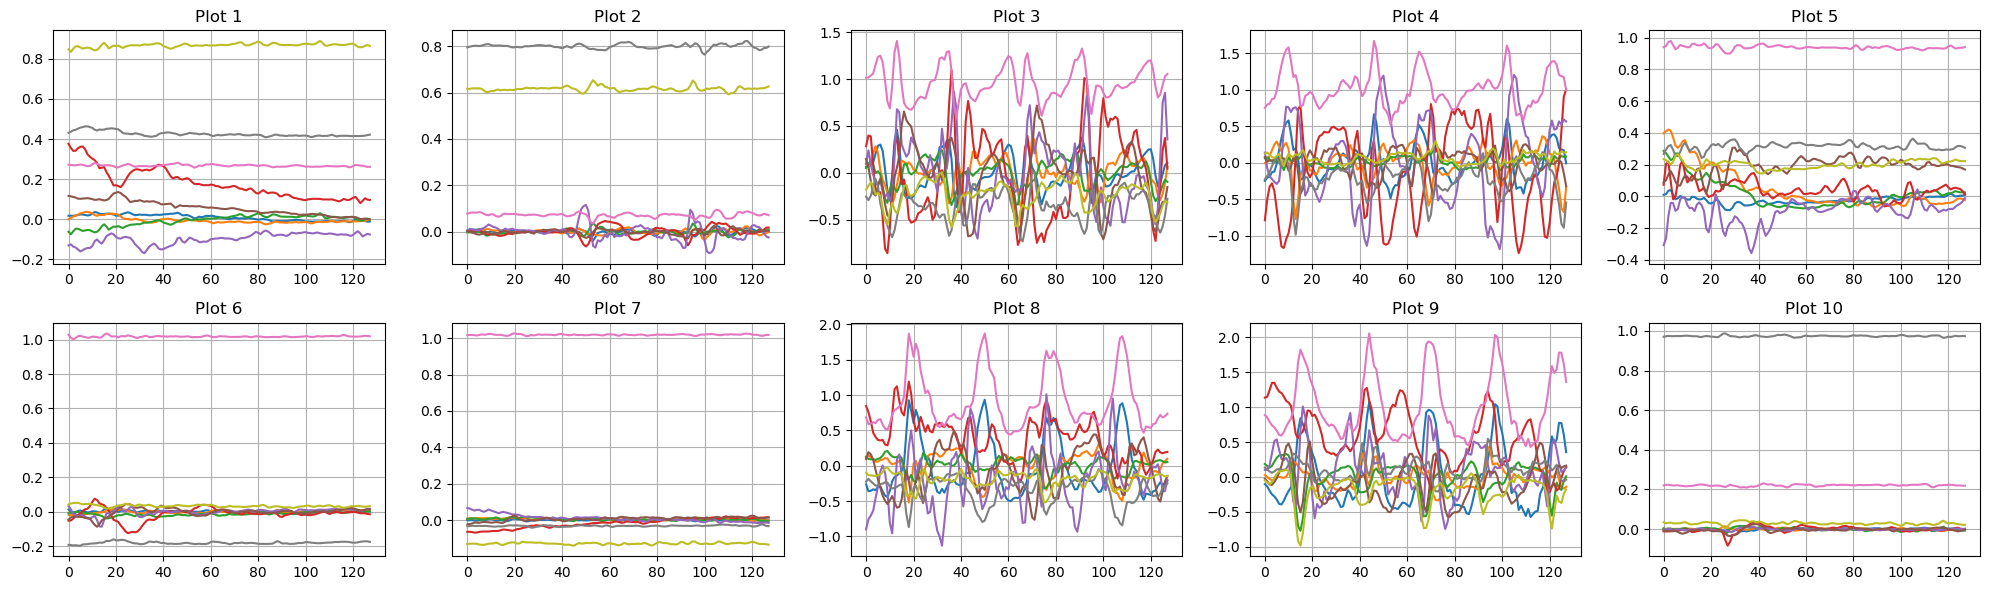

In [54]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()

for i in range(10):
    axes[i].plot(x[i])
    axes[i].grid(True)
    axes[i].set_title(f'Plot {i + 1}')

plt.tight_layout()
plt.show()


In [188]:
# RNN Model
class RNN_Custom_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, num_cls):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          bidirectional=bidirectional)
        self.fully_connected_1 = nn.LazyLinear(num_cls)

    def forward(self, x):
        outputs, hidden = self.rnn(x)
        y= self.fully_connected_1(outputs)
        y = y.mean(dim=1)
        return y

In [189]:
model = RNN_Custom_Model(9, 32, 1, False, 6)
model

RNN_Custom_Model(
  (rnn): RNN(9, 32)
  (fully_connected_1): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [163]:
model(x)

tensor([[-0.0235, -0.1962,  0.0858, -0.0990, -0.0210,  0.1399],
        [ 0.0012, -0.2751,  0.0937, -0.0274,  0.0110,  0.1598],
        [ 0.0127, -0.4063, -0.0981,  0.1210, -0.2321,  0.0161],
        ...,
        [-0.0124, -0.3149, -0.1333,  0.0955, -0.1961, -0.0124],
        [-0.0653, -0.3029, -0.1260,  0.0529, -0.1879, -0.0209],
        [-0.0836, -0.2151,  0.0201, -0.0475,  0.0265,  0.0951]],
       grad_fn=<MeanBackward1>)

In [191]:
model(x).shape

torch.Size([256, 6])

In [192]:
model.fully_connected_1.weight.shape

torch.Size([6, 32])

In [193]:
# Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [194]:
#utils
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [195]:
#train function
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass', num_classes=6).to(device)
    with tqdm(train_loader, unit='batch') as pbar:
        for x_batch, y_batch in pbar:
            if epoch is not None:
                pbar.set_description(f'Epoch {epoch}')
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch).to(device)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train.update(loss.item())
            acc_train(yp, y_batch).to(device)
            pbar.set_postfix(loss=loss_train.avg, accuracy=100. * acc_train.compute().item())
    return model, loss_train.avg, acc_train.compute().item()

In [196]:
# validation fucntion
def evaluate(model, valid_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task='multiclass', num_classes=6).to(device)
        for i, (x_batch, y_batch) in enumerate(valid_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch).to(device)
            loss_valid.update(loss.item())
            acc_valid(yp, y_batch).to(device)
    return loss_valid.avg, acc_valid.compute().item()

In [197]:
,  # Efficient for set hyperparams
#step 1: check forward path on one batch
model = RNN_Custom_Model(9, 128, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.7924, device='cuda:0', grad_fn=<NllLossBackward0>)


In [198]:
#step 2: check backward path on 5 random batch
_, mini_train_dataset = random_split(train_set, (len(train_set) - 500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 6)

In [199]:
model = RNN_Custom_Model(9, 128, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [200]:
num_epochs = 100
for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 84/84 [00:00<00:00, 126.32batch/s, accuracy=94.8, loss=0.19] 


In [78]:

# select best Lr
num_epochs = 2
for lr in [0.9,0.5,0.1, 0.01, 0.001]:
    print(f'Learning rate: {lr}')
    model = RNN_Custom_Model(9, 128, 1, False, 6).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
    for epoch in range(num_epochs):
        model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
        print()

Learning rate: 0.9


Epoch 0: 100%|██████████| 29/29 [00:01<00:00, 28.81batch/s, accuracy=27.8, loss=15.1]


Epoch 1: 100%|██████████| 29/29 [00:00<00:00, 30.06batch/s, accuracy=16.7, loss=69.6]



Learning rate: 0.5


Epoch 0: 100%|██████████| 29/29 [00:00<00:00, 29.50batch/s, accuracy=42.4, loss=1.33]


Epoch 1: 100%|██████████| 29/29 [00:00<00:00, 29.22batch/s, accuracy=50.5, loss=1.1] 



Learning rate: 0.1


Epoch 0: 100%|██████████| 29/29 [00:00<00:00, 29.28batch/s, accuracy=36.9, loss=1.54]


Epoch 1: 100%|██████████| 29/29 [00:00<00:00, 29.61batch/s, accuracy=48.7, loss=1.19]



Learning rate: 0.01


Epoch 0: 100%|██████████| 29/29 [00:00<00:00, 29.15batch/s, accuracy=28.7, loss=1.76]


Epoch 1: 100%|██████████| 29/29 [00:00<00:00, 29.67batch/s, accuracy=39.1, loss=1.68]



Learning rate: 0.001


Epoch 0: 100%|██████████| 29/29 [00:00<00:00, 30.60batch/s, accuracy=13.5, loss=1.8]


Epoch 1: 100%|██████████| 29/29 [00:01<00:00, 27.19batch/s, accuracy=15.9, loss=1.78]

In [80]:

#Create small grid based on the "weight_decay" and the "Learning rate"
num_epochs = 3
for lr in [0.5, 0.9, 0.1, 0.15, 0.2]:
    for wd in [1e-4, 1e-5, 0.]:
        model = RNN_Custom_Model(9, 128, 1, False, 6).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
        print(f'Learning rate: {lr}, Weight decay: {wd}')
        for epoch in range(num_epochs):
            model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
        print()

Learning rate: 0.5, Weight decay: 0.0001


Epoch 2: 100%|██████████| 29/29 [00:01<00:00, 26.84batch/s, accuracy=50.3, loss=1.18]



Learning rate: 0.5, Weight decay: 1e-05


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 29.40batch/s, accuracy=51.2, loss=1.18]



Learning rate: 0.5, Weight decay: 0.0


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 29.29batch/s, accuracy=50.2, loss=1.18]



Learning rate: 0.9, Weight decay: 0.0001


Epoch 2: 100%|██████████| 29/29 [00:01<00:00, 28.96batch/s, accuracy=49.6, loss=1.15]



Learning rate: 0.9, Weight decay: 1e-05


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 29.62batch/s, accuracy=50.7, loss=1.13]



Learning rate: 0.9, Weight decay: 0.0


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 30.09batch/s, accuracy=51.5, loss=1.13]



Learning rate: 0.1, Weight decay: 0.0001


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 29.78batch/s, accuracy=41.4, loss=1.47]



Learning rate: 0.1, Weight decay: 1e-05


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 30.05batch/s, accuracy=41.3, loss=1.47]



Learning rate: 0.1, Weight decay: 0.0


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 29.42batch/s, accuracy=41.9, loss=1.47]



Learning rate: 0.15, Weight decay: 0.0001


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 30.04batch/s, accuracy=45.3, loss=1.36]



Learning rate: 0.15, Weight decay: 1e-05


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 29.88batch/s, accuracy=48.1, loss=1.35]



Learning rate: 0.15, Weight decay: 0.0


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 29.71batch/s, accuracy=44.2, loss=1.37]



Learning rate: 0.2, Weight decay: 0.0001


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 29.90batch/s, accuracy=47.6, loss=1.31]



Learning rate: 0.2, Weight decay: 1e-05


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 29.88batch/s, accuracy=47.3, loss=1.31]



Learning rate: 0.2, Weight decay: 0.0


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 30.35batch/s, accuracy=47.3, loss=1.31]

In [201]:
# Train Model 20 epoch for full train_loader
model = RNN_Custom_Model(9, 128, 3, False, 6).to(device)

In [202]:
model

RNN_Custom_Model(
  (rnn): RNN(9, 128, num_layers=3)
  (fully_connected_1): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [203]:
lr = 0.1
wd = 1e-5
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [204]:
loss_train_history = []
acc_train_history = []

loss_val_history = []
acc_val_history = []

best_loss_val = torch.inf
epoch_counter = 0

In [205]:
num_epochs = 20
for epoch in range(num_epochs):
    #Train
    model, loss_train, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    #valid
    loss_valid, acc_valid = evaluate(model, test_loader, loss_fn)

    loss_train_history.append(loss_train)
    acc_train_history.append(acc_train)
    loss_val_history.append(loss_valid)
    acc_val_history.append(acc_valid)

    if loss_valid < best_loss_val:
        torch.save(model, f'model.pt')
        print('model Saved !')
        best_loss_val = loss_valid
    print(f'Validation: Loss={loss_valid:.2}, Accuracy={acc_valid:.2}')
    print()

    epoch_counter += 1

Epoch 0: 100%|██████████| 29/29 [00:01<00:00, 15.12batch/s, accuracy=29, loss=1.62]  


model Saved !
Validation: Loss=1.3, Accuracy=0.42



Epoch 1: 100%|██████████| 29/29 [00:01<00:00, 15.12batch/s, accuracy=45.1, loss=1.21]


model Saved !
Validation: Loss=1.2, Accuracy=0.43



Epoch 2: 100%|██████████| 29/29 [00:01<00:00, 15.24batch/s, accuracy=53.7, loss=1.05]


model Saved !
Validation: Loss=1.2, Accuracy=0.51



Epoch 3: 100%|██████████| 29/29 [00:01<00:00, 15.07batch/s, accuracy=62.7, loss=0.96] 


model Saved !
Validation: Loss=0.97, Accuracy=0.59



Epoch 4: 100%|██████████| 29/29 [00:01<00:00, 15.27batch/s, accuracy=71.9, loss=0.742]


model Saved !
Validation: Loss=0.77, Accuracy=0.69



Epoch 5: 100%|██████████| 29/29 [00:01<00:00, 15.03batch/s, accuracy=75.2, loss=0.651]


model Saved !
Validation: Loss=0.64, Accuracy=0.75



Epoch 6: 100%|██████████| 29/29 [00:01<00:00, 15.04batch/s, accuracy=79.4, loss=0.517]


model Saved !
Validation: Loss=0.64, Accuracy=0.74



Epoch 7: 100%|██████████| 29/29 [00:01<00:00, 15.10batch/s, accuracy=83.1, loss=0.437]


Validation: Loss=0.65, Accuracy=0.77



Epoch 8: 100%|██████████| 29/29 [00:01<00:00, 15.18batch/s, accuracy=84, loss=0.406]  


Validation: Loss=0.67, Accuracy=0.75



Epoch 9: 100%|██████████| 29/29 [00:01<00:00, 15.10batch/s, accuracy=84.2, loss=0.399]


model Saved !
Validation: Loss=0.58, Accuracy=0.77



Epoch 10: 100%|██████████| 29/29 [00:01<00:00, 14.64batch/s, accuracy=83.9, loss=0.402]


Validation: Loss=0.58, Accuracy=0.78



Epoch 11: 100%|██████████| 29/29 [00:01<00:00, 15.12batch/s, accuracy=84.5, loss=0.387]


Validation: Loss=0.59, Accuracy=0.78



Epoch 12: 100%|██████████| 29/29 [00:01<00:00, 15.20batch/s, accuracy=83.1, loss=0.448]


Validation: Loss=0.66, Accuracy=0.75



Epoch 13: 100%|██████████| 29/29 [00:01<00:00, 15.10batch/s, accuracy=84.9, loss=0.387]


model Saved !
Validation: Loss=0.56, Accuracy=0.81



Epoch 14: 100%|██████████| 29/29 [00:01<00:00, 15.17batch/s, accuracy=86.3, loss=0.349]


Validation: Loss=0.58, Accuracy=0.8



Epoch 15: 100%|██████████| 29/29 [00:01<00:00, 15.14batch/s, accuracy=86.8, loss=0.345]


Validation: Loss=0.63, Accuracy=0.78



Epoch 16: 100%|██████████| 29/29 [00:01<00:00, 15.11batch/s, accuracy=86.6, loss=0.335]


Validation: Loss=0.56, Accuracy=0.79



Epoch 17: 100%|██████████| 29/29 [00:01<00:00, 14.80batch/s, accuracy=85.9, loss=0.354]


Validation: Loss=0.67, Accuracy=0.78



Epoch 18: 100%|██████████| 29/29 [00:01<00:00, 14.95batch/s, accuracy=87.8, loss=0.32] 


Validation: Loss=0.58, Accuracy=0.81



Epoch 19: 100%|██████████| 29/29 [00:01<00:00, 15.18batch/s, accuracy=87.5, loss=0.315]


Validation: Loss=0.57, Accuracy=0.82



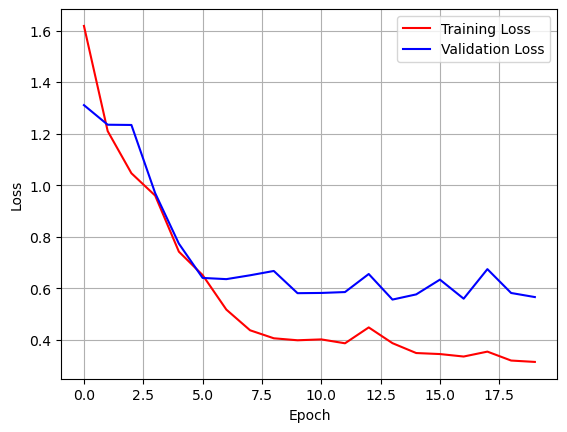

In [206]:

plt.plot(range(epoch_counter), loss_train_history, 'r-', label='Training Loss')
plt.plot(range(epoch_counter), loss_val_history, 'b-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

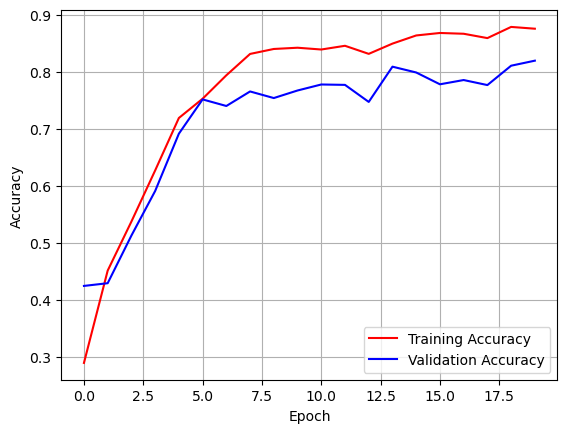

In [207]:
plt.plot(range(epoch_counter), acc_train_history, 'r-', label='Training Accuracy')
plt.plot(range(epoch_counter), acc_val_history, 'b-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()